# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [482]:
import pandas as pd
import numpy as np
from collections import defaultdict 
import math
import json
import re
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,classification_report, f1_score,average_precision_score
import pickle
import joblib


sns.set_theme(style="whitegrid")
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


# Data exploration

In [386]:
#checking for outliers and Nans
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [492]:
# number of customers
profile.shape[0]

17000

In [490]:
#checking basic statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


118    2175
101       5
Name: age, dtype: int64

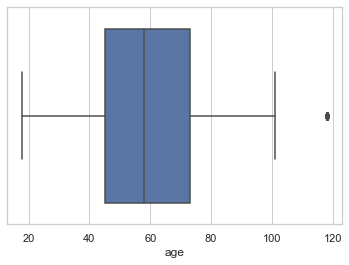

In [527]:
sns.boxplot(profile.age);

profile.age[profile.age > 100].value_counts()

In [387]:
#checking for outliers and Nans
transcript.isna().sum()


person    0
event     0
value     0
time      0
dtype: int64

# Data Wrangling / Cleaning

In [2]:
#clean portfolio data
defaultdict()

def clean_portfolio(df):
    
    """
    The function dummies the channels in the portfolio df and returns a new datframe.

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    portfolio = df.copy()
    
    #extract channels
    channels = set()

    for label, value in portfolio["channels"].iteritems():
        for i in value:
            channels.add(i)

    #create dummy variables for channels
    for channel in channels:
        portfolio[channel] = portfolio["channels"].apply(lambda x: 1 if channel in x else 0)

    portfolio_cleaned = portfolio.drop("channels", axis =1).rename(columns={"id":"offer_id", 
                                                                            "offer_type":"offer_category"})
    
    #create new offer types to dinstinguish  
    portfolio_cleaned["offer_type"] = portfolio["offer_type"].str.cat(portfolio["reward"].astype(str), 
                                    sep='_').str.cat(portfolio["difficulty"].astype(str), 
                                                    sep ='_').str.cat(portfolio["duration"].astype(str),sep ='_')

    
    return  portfolio_cleaned




In [10]:
clean_portfolio(portfolio)


,reward,difficulty,duration,offer_category,offer_id,social,email,web,mobile,offer_type
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,1,1,discount_2_10_7


In [698]:
def generate_person_ids():
    
    """
    Helper function to create ids as integers.

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    ids_old = profile.id.unique()
    ids_new = np.arange(1,profile.id.unique().shape[0]+1,1)
    ids_new = dict(zip(ids_old,ids_new))

    return ids_new

    


def clean_profile(df):
    
    """
    The function dummies the channels in the portfolio df and returns a new datframe.

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    profile = df.copy()
    
    #check and drop NaNs
    #cols_drop = profile[profile["gender"].isna()].index.values
    #profile = profile.drop(index=cols_drop)

    #transform became_member_on column to datetime
    def transform_to_datetime(x):
        x = str(x)

        return datetime.date(int(x[:4]),int(x[4:6]),int(x[6:]))

    #create columns for year, quarter and day of membership start
    profile.became_member_on = pd.to_datetime(profile.became_member_on.transform(transform_to_datetime))
    profile["became_member_on_yr"] = profile["became_member_on"].dt.year
    profile["became_member_on_qtr"] = profile["became_member_on"].dt.quarter
    
    #simplify customer ids using integers
    profile.id = profile.id.map(generate_person_ids())
    
    
    
    #get dummies from gender column
    dummies_gender = pd.get_dummies(profile["gender"],  prefix="gender", prefix_sep='_',  dtype=int)
    profile = profile.merge(dummies_gender, left_index = True, right_index=True, how="outer")#.drop(["gender","became_member_on"], axis=1)


    profile_cleaned = profile

    
    return profile_cleaned
    

In [257]:
clean_profile(profile)



,age,id,income,became_member_on_yr,became_member_on_qtr,became_member_on_day,gender_F,gender_M,gender_O
0,118,1,NaN,2017,1,12,0,0,0
1,55,2,112000.0,2017,3,15,1,0,0
2,118,3,NaN,2018,3,12,0,0,0
3,75,4,100000.0,2017,2,9,1,0,0
4,118,5,NaN,2017,3,4,0,0,0
...,...,...,...,...,...,...,...,...,...
16995,45,16996,54000.0,2018,2,4,1,0,0
16996,61,16997,72000.0,2018,3,13,0,1,0
16997,49,16998,73000.0,2017,1,26,0,1,0
16998,83,16999,50000.0,2016,1,7,1,0,0


In [4]:
def clean_transcript(df):
    """
    The function drops NaNs and transforms the person ids to integers

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    transcript = df.copy()
    #clean transcript data
    transcript["offer_id"] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0]== 'offer id' or list(x.keys())[0] == 'offer_id' else np.nan)
    transcript["value"] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0]== 'amount' else np.nan)
    
    #simplify customer ids using integers
    transcript.person = transcript.person.map(generate_person_ids())

    transcript_cleaned = transcript
    
    return transcript_cleaned






In [582]:
clean_transcript(transcript)

,person,event,value,time,offer_id
0,4,offer received,NaN,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,5,offer received,NaN,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,6,offer received,NaN,0,2906b810c7d4411798c6938adc9daaa5
3,7,offer received,NaN,0,fafdcd668e3743c1bb461111dcafc2a4
4,8,offer received,NaN,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,16960,transaction,1.59,714,NaN
306530,16965,transaction,9.53,714,NaN
306531,16980,transaction,3.61,714,NaN
306532,16988,transaction,3.53,714,NaN


In [247]:
def merge_dataframes(df1=transcript, df2=profile, df3=portfolio):
    
    
    """
    The function does the following merges demographic data with transcript data, create single offer types, 
    and maps reward on value column
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    transcript = clean_transcript(df1.copy())
    profile = clean_profile(df2.copy())
    portfolio = clean_portfolio(df3.copy())
    
    #descriptive statistics & visualizations

    #merge transcript with profile data
    df_merged = transcript.merge(profile, left_on="person", right_on="id", how="outer").drop(["id"], axis=1)

    #concate offer columns to create distinguishable names
    #portfolio["offer_type"] = portfolio["offer_type"].str.cat(portfolio["reward"].astype(str), 
                                    #sep='_').str.cat(portfolio["difficulty"].astype(str), 
                                                    #sep ='_').str.cat(portfolio["duration"].astype(str),sep ='_')
    
    #map offer types on ids
    df_merged["offer_type"] = df_merged["offer_id"].map(dict(zip(portfolio["offer_id"],portfolio["offer_type"])))

    #map rewards on value column
    reward = df_merged.offer_id.map(dict(zip(portfolio["offer_id"],portfolio["reward"])))
    df_merged["value"] = df_merged["value"].mask(df_merged["value"].isnull(),reward) 
    
    #drop NaNs
    #df_merged = df_merged.dropna(subset=['gender', 'income', "age"], axis =0)
    
    return df_merged


In [248]:
merge_dataframes()


,person,event,value,time,offer_id,age,income,became_member_on_yr,became_member_on_qtr,became_member_on_day,gender_F,gender_M,gender_O,gender_nan,offer_type
0,4,offer received,5.00,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,0,bogo_5_5_7
1,4,offer viewed,5.00,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,0,bogo_5_5_7
2,4,transaction,19.89,132,NaN,75,100000.0,2017,2,9,1,0,0,0,NaN
3,4,offer completed,5.00,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,0,bogo_5_5_7
4,4,transaction,17.78,144,NaN,75,100000.0,2017,2,9,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,5105,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,118,NaN,2017,3,26,0,0,0,1,bogo_10_10_5
306530,5105,offer viewed,10.00,594,4d5c57ea9a6940dd891ad53e9dbe8da0,118,NaN,2017,3,26,0,0,0,1,bogo_10_10_5
306531,11904,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,58,78000.0,2016,4,20,1,0,0,0,bogo_10_10_5
306532,11904,offer viewed,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,58,78000.0,2016,4,20,1,0,0,0,bogo_10_10_5


# Descriptive Statistics

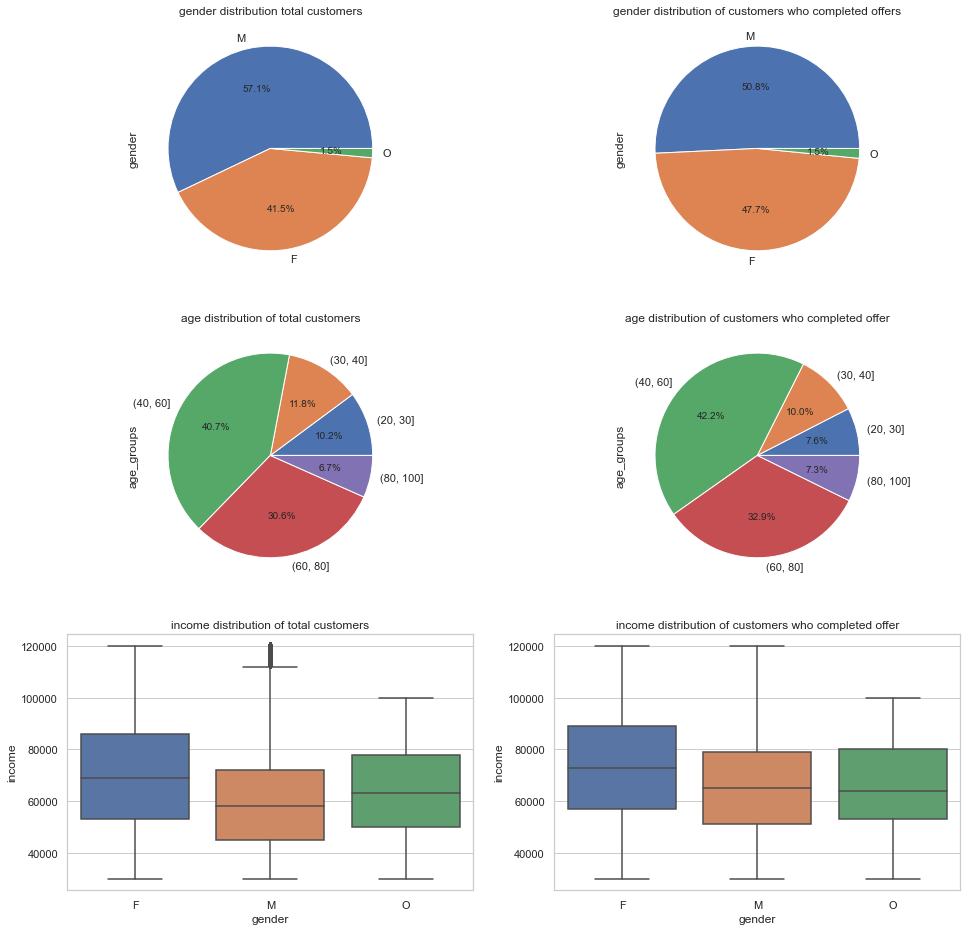

In [418]:
#compare demographic data of all vs customers that completed offers

#initializing figure 
fi, ax = plt.subplots(3,2, figsize=(16,16))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]
ax5 = ax[2][0]
ax6 = ax[2][1]

#initialize dataframes
customers_all = merge_dataframes(transcript, profile, portfolio).dropna(subset=['gender', 'income', "age"], axis =0)
customers_compl = customers_all[customers_all["event"]=="offer completed"][["age","gender","value","income","offer_type"]].dropna()

#create age-brackets
age_groups_all  = pd.cut(customers_all['age'], [20,30,40,60,80,100],20).rename("age_groups").value_counts().sort_index(axis = 0)
age_groups_compl = pd.cut(customers_compl['age'], [20,30,40,60,80,100],20).rename("age_groups").value_counts().sort_index(axis = 0)


#compare gender distribution
ax1 = (customers_all.gender.value_counts() / customers_all.shape[0]).plot.pie( ax= ax1, autopct='%1.1f%%')
ax2 = (customers_compl.gender.value_counts() / customers_compl.shape[0]).plot.pie(ax= ax2, autopct='%1.1f%%')

#compare age distribution
ax3 = (age_groups_all / age_groups_all.sum()).plot.pie(ax= ax3, autopct='%1.1f%%')
ax4 =  (age_groups_compl / age_groups_compl.sum()).plot.pie(ax= ax4,autopct='%1.1f%%')


#compare income distribution
#ax5 = sns.histplot(customers_all,x="income", hue="gender",multiple="stack",palette="light:m_r",edgecolor=".3",
                   #linewidth=.5,log_scale=False,bins=50,ax=ax5,stat ="density")



#ax6 = sns.histplot(customers_compl,x="income", hue="gender",multiple="stack",palette="light:m_r",edgecolor=".3",
                   #linewidth=.5,bins=50,ax=ax6,stat ="density")


ax5 = sns.boxplot(x="gender", y="income", data=customers_all, ax=ax5)
#ax5 = sns.swarmplot(x="gender", y="income", data=customers_all, color=".25",ax=ax5)
ax6 = sns.boxplot(x="gender", y="income", data=customers_compl, ax=ax6)



#plot title
ax1.set_title('gender distribution total customers')
ax2.set_title('gender distribution of customers who completed offers')
ax3.set_title('age distribution of total customers')
ax4.set_title('age distribution of customers who completed offer');
ax5.set_title('income distribution of total customers')
ax6.set_title('income distribution of customers who completed offer');

#set scale of y axis
#ax5.set_ylim(0,.00003)
#ax6.set_ylim(0,.00003)



In [407]:
merge_dataframes(transcript, profile, portfolio)

,person,event,value,time,offer_id,age,income,became_member_on_yr,became_member_on_qtr,became_member_on_day,gender_F,gender_M,gender_O,offer_type
0,4,offer received,5.00,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,bogo_5_5_7
1,4,offer viewed,5.00,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,bogo_5_5_7
2,4,transaction,19.89,132,NaN,75,100000.0,2017,2,9,1,0,0,NaN
3,4,offer completed,5.00,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,2017,2,9,1,0,0,bogo_5_5_7
4,4,transaction,17.78,144,NaN,75,100000.0,2017,2,9,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,5105,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,118,NaN,2017,3,26,0,0,0,bogo_10_10_5
306530,5105,offer viewed,10.00,594,4d5c57ea9a6940dd891ad53e9dbe8da0,118,NaN,2017,3,26,0,0,0,bogo_10_10_5
306531,11904,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,58,78000.0,2016,4,20,1,0,0,bogo_10_10_5
306532,11904,offer viewed,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,58,78000.0,2016,4,20,1,0,0,bogo_10_10_5


In [497]:
demographic_data.groupby(["offer_type","gender"])["gender"].count()

offer_type        gender
bogo_10_10_5      F         1746
                  M         1519
                  O           45
bogo_10_10_7      F         1857
                  M         1741
                  O           59
bogo_5_5_5        F         1899
                  M         2137
                  O           67
bogo_5_5_7        F         1999
                  M         2115
                  O           74
discount_2_10_10  F         2216
                  M         2721
                  O           66
discount_2_10_7   F         1851
                  M         2000
                  O           60
discount_3_7_7    F         2206
                  M         2613
                  O           67
discount_5_20_10  F         1703
                  M         1620
                  O           63
Name: gender, dtype: int64

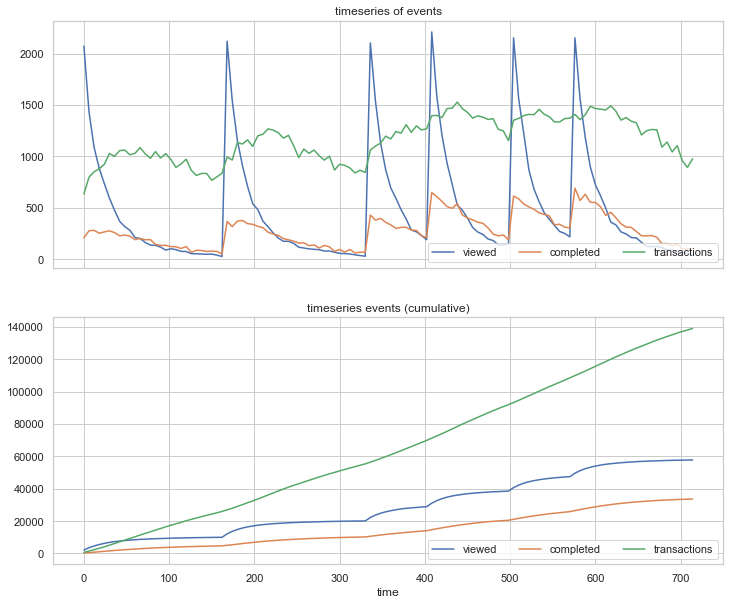

In [577]:
#Data visualizations timeseries

#initialize figure and axes
f, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 10), sharex=True)

data = merge_dataframes(transcript, profile, portfolio).set_index("time")["event"]

#plot timeseries 

#offers_received = data[data=="offer received"].sort_index().groupby(level=0).count().plot(ax =ax1)
offers_viewed = data[data=="offer viewed"].groupby(level=0).count().rename("viewed").plot(ax =ax1)
offers_completed = data[data=="offer completed"].groupby(level=0).count().rename("completed").plot(ax =ax1)
transactions = data[data=="transaction"].groupby(level=0).count().rename("transactions").plot(ax =ax1)

offers_viewed = data[data=="offer viewed"].groupby(level=0).count().cumsum().rename("viewed").plot(ax =ax2)
offers_completed = data[data=="offer completed"].groupby(level=0).count().cumsum().rename("completed").plot(ax =ax2)
transactions = data[data=="transaction"].groupby(level=0).count().cumsum().rename("transactions").plot(ax =ax2)


ax1.set_title('timeseries of events')
ax1.legend(ncol=3, loc="lower right", frameon=True)

ax2.set_title('timeseries events (cumulative)')
ax2.legend(ncol=3, loc="lower right", frameon=True);



/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


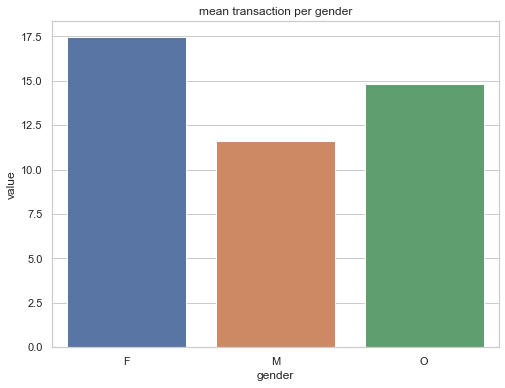

In [578]:
#mean transaction
data = merge_dataframes(transcript, profile, portfolio).set_index("time")
mean_trans = data[data["event"]=="transaction"].groupby("gender")["value"].mean()
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(mean_trans.index, mean_trans, ax = ax);

ax.set_title("mean transaction per gender");




No handles with labels found to put in legend.


,offers_sent,offers_viewed,offers_completed,perc_completed,perc_viewed,diff_viewed_completed
discount_2_10_10,7597,7327,5317.000000,0.699882,0.964460,0.735422
discount_3_7_7,7646,7337,5156.000000,0.674340,0.959587,0.714753
bogo_5_5_7,7677,4171,4354.000000,0.567149,0.543311,1.023837
bogo_5_5_5,7571,7264,4296.000000,0.567428,0.959451,0.607978
discount_2_10_7,7632,4118,4017.000000,0.526336,0.539570,0.986766
bogo_10_10_7,7658,6716,3688.000000,0.481588,0.876991,0.604597
discount_5_20_10,7668,2663,3420.000000,0.446009,0.347287,1.098722
bogo_10_10_5,7593,7298,3331.000000,0.438694,0.961148,0.477545
informational_0_0_3,7618,6687,nan,nan,0.877789,nan
informational_0_0_4,7617,4144,nan,nan,0.544046,nan


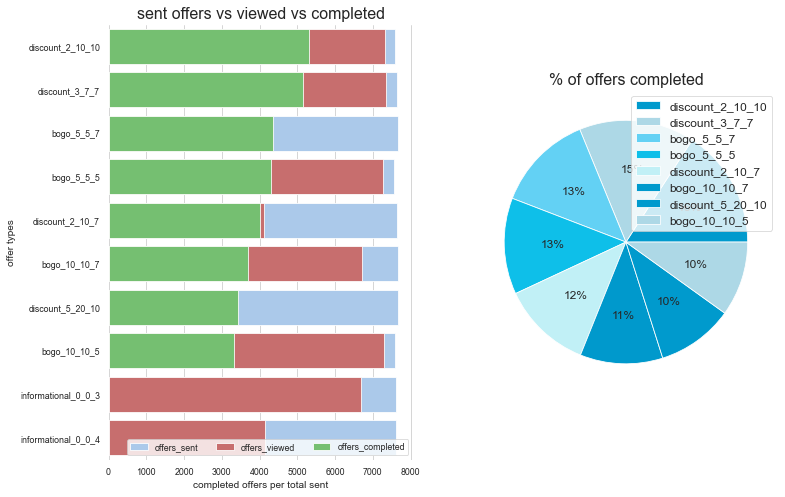

In [444]:
#compare offer types with respect to rates of receipts, views, completion
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":16,"axes.labelsize":10})   

data = merge_dataframes(transcript, profile, portfolio)


offers_completed = data[data["event"]=="offer completed"]["offer_type"].value_counts().rename("offers_completed")
offers_sent = data[data["event"]=="offer received"]["offer_type"].value_counts().rename("offers_sent")
offers_viewed = data[data["event"]=="offer viewed"]["offer_type"].value_counts().rename("offers_viewed")

#create dataframe
df_combined = pd.concat([offers_sent,offers_viewed,offers_completed ], axis=1).sort_values(by="offers_completed", ascending=False)

df_combined ["perc_completed"] = df_combined ["offers_completed"] / df_combined["offers_sent"]
df_combined ["perc_viewed"] =   df_combined ["offers_viewed"] / df_combined["offers_sent"]
df_combined ["diff_viewed_completed"] = 1-(df_combined ["perc_viewed"] - df_combined ["perc_completed"])
#offers_total = offers_total[["offers_sent","offers_viewed","perc_viewed","offers_completed", "perc_completed","diff_viewed_completed"]]



# initialize figure and axes
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))

# Plot completed vs. sent offers
sns.set_color_codes("pastel")


ax1= sns.barplot(x="offers_sent", y=df_combined.index, data=df_combined,
           label="offers_sent", color="b",ax=ax1)

sns.set_color_codes("muted")

ax1= sns.barplot(x="offers_viewed", y=df_combined.index, data=df_combined,
            label="offers_viewed", color="r", ax=ax1)
 
ax1= sns.barplot(x="offers_completed", y=df_combined.index, data=df_combined,
            label="offers_completed", color="g", ax=ax1)




ax1.legend(ncol=3, loc="lower right", frameon=True)
ax1.set(ylabel="offer types",xlabel="completed offers per total sent")
ax1.set_title('sent offers vs viewed vs completed')
sns.despine(left=True, bottom=True)


#plot % of completed offers
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

ax2.pie(df_combined["offers_completed"].dropna(),  autopct='%1.f%%', colors =color_palette_list);
ax2.set_title('% of offers completed')
ax2.legend(ncol=3, loc="lower right", frameon=False)
ax2.legend(loc='best', labels=df_combined["offers_completed"].dropna().index.values, fontsize='medium')

#df_combined
cm = sns.light_palette("green", as_cmap=True)
df_combined.style.bar(subset=['diff_viewed_completed'], align='mid', color=['#d65f5f', '#5fba7d'])
#df_combined.style.background_gradient(subset=['perc_completed',"diff_viewed_completed"], cmap=cm)


Text(0.5, 1.0, 'channels offers completed')

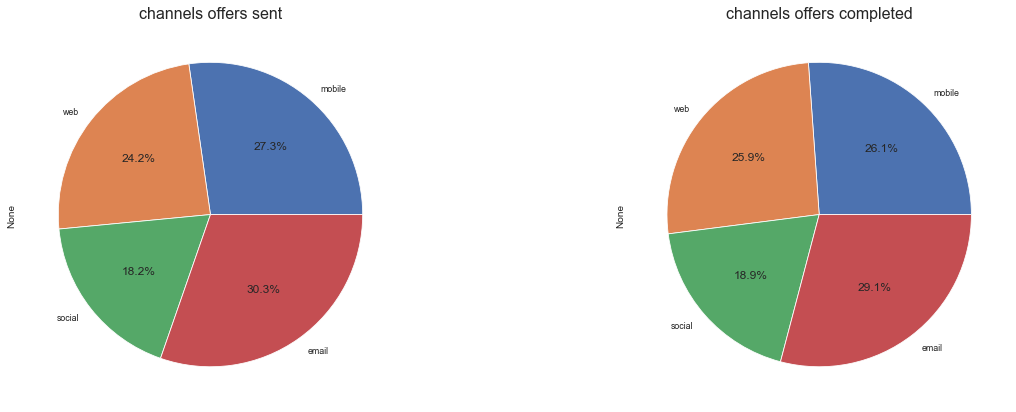

In [424]:
#statistics on channel distributions

channels = clean_portfolio(portfolio).iloc[:,5:]

df = merge_dataframes(transcript, profile, portfolio)[["event","offer_type"]]
df = df.merge(channels,how="left", on ="offer_type")

#channels = channels.merge(portfolio[["offer_type","mobile","social","web","email"]], how="left", on ="offer_type")

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))
df[df["event"] == "offer received"].iloc[:,2:].apply(lambda x: x.sum() / x.shape[0]).plot.pie(ax = ax1, autopct='%1.1f%%');
df[df["event"] == "offer completed"].iloc[:,2:].apply(lambda x: x.sum() / x.shape[0]).plot.pie(ax = ax2, autopct='%1.1f%%');


ax1.set_title('channels offers sent')
ax2.set_title('channels offers completed');


# Model Development

In [249]:
def find_ctm_offer_cpl(df1):
    
    """
    The function extracts all customers that completed an offer.
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    #initialize dataframes
    transcript = clean_transcript(df1.copy())
    portfolio_ = clean_portfolio(portfolio.copy())
    transcript["time"] = transcript["time"] / 24
    
    #get duration for each offer
    validity = dict(set(zip(portfolio_.offer_id,portfolio_.duration)))
    
    #df_user_all = pd.DataFrame()
    df_user_all = transcript.groupby(["person","offer_id","event"])["time"].min().unstack()
    df_user_all["valid"] = None
    
    
    #iterates through each user and appends offers completed
    for counter, user in enumerate(df_user_all.reset_index()["person"].unique()):

        #df_user = transcript[transcript["person"]==user].sort_values(by="time")
        df_user = df_user_all.loc[user,:]


        for label, row in df_user.iterrows():
            
            if row.iloc[:-1].isna().sum()>=1:
                df_user_all.loc[(user, label),"valid"] = False

            elif row.iloc[1] - row.iloc[0] > validity[label]:
                df_user_all.loc[(user, label),"valid"] = False

            else: 
                df_user_all.loc[(user, label),"valid"] = True
    

            
    df_user_all = df_user_all.reset_index()
    df_user_all["duration"] = df_user_all["offer_id"].map(validity)
    df_user_all.to_csv("offer_completed.csv")
    
    return df_user_all


In [250]:
find_ctm_offer_cpl(transcript)

event,person,offer_id,offer received,offer viewed,offer completed,valid,duration
0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,14.0,14.50,NaN,False,10
1,1,2298d6c36e964ae4a3e7e9706d1fb8c2,21.0,21.00,23.00,True,7
2,1,2906b810c7d4411798c6938adc9daaa5,7.0,9.00,NaN,False,7
3,1,fafdcd668e3743c1bb461111dcafc2a4,17.0,17.00,23.00,True,10
4,2,3f207df678b143eea3cee63160fa8bed,21.0,NaN,NaN,False,4
...,...,...,...,...,...,...,...
63283,16999,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,21.50,17.25,True,7
63284,16999,ae264e3637204a6fb9bb56bc8210ddfd,24.0,26.00,24.75,True,7
63285,17000,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.25,2.25,True,7
63286,17000,3f207df678b143eea3cee63160fa8bed,14.0,NaN,NaN,False,4


In [251]:
def get_ctm_informational_new():
    
    """
    The function returns records for persons that completed transactions for informational offers.
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """

    df = merge_dataframes()
    portfolio_ = clean_portfolio(portfolio.copy())
    
    #get transactions and informational offers  
    filter_ = df["offer_type"][(df["offer_type"].str.contains("informational")== True) | (df["event"] == "transaction") ].index
    df = df[df.index.isin(filter_)].sort_values(by="time")

    df = df.groupby(["person","event"])["offer_id","time"].agg({'offer_id' : list,'time' : list}).unstack().dropna()
    
    # transform columns to array
    idx = df.index
    off_received = np.array(df["offer_id"]["offer received"])
    off_viewed = np.array(df["offer_id"]["offer viewed"])
    time_received = np.array(df["time"]["offer received"])
    time_viewed = np.array(df["time"]["offer viewed"])
    
    
    #loop through arrays to match received with viewed offer list idx
    idx_received = {}
    idx_viewed = {}
    off_viewed_matched = []
    

    
    for ct, i in enumerate(off_viewed):
        idx_received[ct] = off_received[ct].index(i[0])
        off_viewed_matched.append(i[0])
        idx_viewed[ct] = off_viewed[ct].index(i[0])
        
    
    #create new dataframe with only valid records
    time_received_matched = np.array([ i[idx_received[ct]] for ct, i in enumerate(time_received)]) / 24
    time_viewed_matched = np.array([ i[idx_viewed[ct]] for ct, i in enumerate(time_viewed)]) / 24
    transactions = [(np.array(i)/24) for i in df["time"]["transaction"] ] 
    
    df = pd.DataFrame(data =[off_viewed_matched,
                              time_received_matched,
                              time_viewed_matched,
                              transactions]).T.set_index(idx.values).rename(columns={0:"offer_id",1:"day_received",2:"day_viewed",3:"transactions",})
    
    validity = dict(set(zip(portfolio_.offer_id,portfolio_.duration)))
    df["duration "]= df.iloc[:,0].map(validity)

    #check if transaction occured during validity period
    valid_transactions = []
    
    
    for ct, i in enumerate(np.array(df["transactions"])):
        
        # check if transaction after receipt
        check1 = np.array(i)[np.array(i) >= time_viewed_matched[ct]]
        
        #check if transaction before expiration date
        check2 = np.any((check1 <= time_received_matched[ct] + validity[off_viewed_matched[ct]]))
        valid_transactions.append(check2)

    # crete new column for validation check
    df["valid"] = valid_transactions
    
    # filter records that are valid
    df = df.reset_index().rename(columns={"index":"person"})
    
    df.to_csv("promotions_completed.csv")
    return df




In [252]:
get_ctm_informational_new()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,person,offer_id,day_received,day_viewed,transactions,duration,valid
0,3,5a8bc65990b245e5a138643cd4eb9837,24,27.75,"[5.5, 14.5, 18.75, 19.75, 26.5, 29.0]",3,False
1,4,5a8bc65990b245e5a138643cd4eb9837,7,9,"[5.5, 6.0, 9.25, 10.0, 15.75, 21.25, 22.25]",3,True
2,5,3f207df678b143eea3cee63160fa8bed,14,14,"[9.75, 11.0, 25.5]",4,False
3,10,5a8bc65990b245e5a138643cd4eb9837,7,9.25,"[2.5, 6.75, 14.75, 16.5, 19.25, 22.25]",3,False
4,14,5a8bc65990b245e5a138643cd4eb9837,14,14,"[8.75, 17.75, 19.0, 20.75, 21.5, 26.25]",3,False
...,...,...,...,...,...,...,...
8044,16992,3f207df678b143eea3cee63160fa8bed,17,17.75,"[5.0, 15.75, 19.25, 19.5, 29.5]",4,True
8045,16995,3f207df678b143eea3cee63160fa8bed,17,17.5,"[0.0, 5.0, 9.75, 10.0, 13.5, 17.5, 18.5, 29.75]",4,True
8046,16996,5a8bc65990b245e5a138643cd4eb9837,17,19.25,"[2.5, 3.5, 8.0, 10.25, 13.5, 26.75, 28.75]",3,False
8047,16997,5a8bc65990b245e5a138643cd4eb9837,0,1.75,"[5.25, 11.25, 11.5, 14.75, 16.25, 17.5, 27.25]",3,False


In [699]:
def prepare_data():
    
    """
    The function does the following merges demographic data with transcript data, create single offer types, 
    and maps reward on value column
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    
    # get customer-offer-matrix
    df1 = pd.read_csv("offer_completed.csv")[["person","offer_id","valid"]]
    df2 = pd.read_csv("promotions_completed.csv")[["person","offer_id","valid"]]
    #ctm_offer_matrix = find_ctm_offer_cpl(transcript).append(get_ctm_informational_new())
    ctm_offer_matrix = df1.append(df2)
    
    
    portfolio_ = clean_portfolio(portfolio.copy())
    profile_ = clean_profile(profile.copy())
    
    # merge with demographic data
    df_merged = ctm_offer_matrix.merge(profile_, left_on ="person", 
                                       right_on ="id", how ="left").drop(["id","person"], axis =1)
    df_merged = df_merged.merge(portfolio_[["offer_id","mobile","social","web","email"]], how="left", 
                                on ="offer_id")
    

    
    # map offer ids to offer categories
    offer_categories = dict(set(zip(portfolio_.offer_id,portfolio_.offer_category)))
    df_merged.offer_id = df_merged.offer_id.map(offer_categories)



    
    return df_merged.dropna()
    




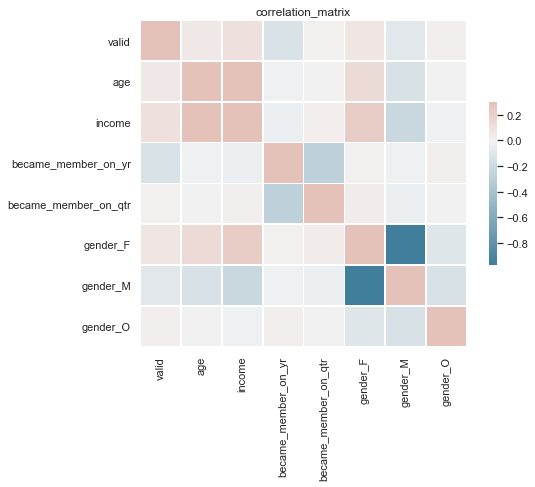

In [732]:
f, ax = plt.subplots(figsize=(8, 6))

corr = prepare_data().iloc[:,:11].dropna().corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

ax.set_title("correlation_matrix");

# Model Selection comparing two classifiers

In [705]:
def regression_model(*params):
    
    
    """
    The function does the following merges demographic data with transcript data, create single offer types, 
    and maps reward on value column
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    df = prepare_data().drop(["gender","became_member_on"], axis=1)
    
    #instantiate regressor
    logr = lm.LogisticRegression()


    #get x ans y
    X = df.iloc[:,2:9]
    y = df["valid"]

    #train-test-split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

    #train and predict
    logr.fit(X_train,Y_train)
    y_pred_test = logr.predict(X_test)

    logr.score(X_test,Y_test)
    print("Score:")
    print(classification_report(Y_test, y_pred_test))
    print("Feature Importances:")
    display(pd.DataFrame(data={"coefficient": logr.coef_[0], 
                               "coefficient(abs)": np.absolute(logr.coef_)[0]}, 
                         index=X.columns).sort_values(by="coefficient(abs)", ascending=False))
    
    return  



regression_model()



Score:
              precision    recall  f1-score   support

       False       0.58      0.87      0.70      7089
        True       0.48      0.15      0.23      5354

    accuracy                           0.56     12443
   macro avg       0.53      0.51      0.46     12443
weighted avg       0.54      0.56      0.50     12443

Feature Importances:


,coefficient,coefficient(abs)
age,0.003124,0.003124
became_member_on_yr,-0.000538,0.000538
gender_M,-0.000221,0.000221
gender_F,0.000201,0.000201
became_member_on_qtr,0.000068,0.000068
gender_O,0.000020,0.000020
income,0.000010,0.000010


In [706]:
# from sklearn.multioutput import MultiOutputClassifier

def classifier_model(**args):
    
    """
    The function does the following merges demographic data with transcript data, create single offer types, 
    and maps reward on value column
    

    :param model: 
    :param model_filepath:
    :return: 
    
    """
    
    df = prepare_data().drop(["gender","became_member_on"], axis=1)
    
    #instantiate regressor
    rf = RandomForestClassifier(bootstrap=False, n_estimators=100)


    #get x ans y
    X = df.iloc[:,2:9]
    y = df["valid"]
    
    #train-test-split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

    #train and predict
    rf.fit(X_train,Y_train)
    y_pred_test = rf.predict(X_test)

    rf.score(X_test,Y_test)
    
    print("Score:")
    print(classification_report(Y_test, y_pred_test))
    
    print("Feature Importances:") 
    for f in range(len(X.columns)):
        print("%s : %f " % (X.columns[f],rf.feature_importances_[f]))

    
    return 

 

classifier_model()

Score:
              precision    recall  f1-score   support

       False       0.62      0.73      0.67      7114
        True       0.54      0.41      0.47      5329

    accuracy                           0.60     12443
   macro avg       0.58      0.57      0.57     12443
weighted avg       0.59      0.60      0.59     12443

Feature Importances:
age : 0.433156 
income : 0.383866 
became_member_on_yr : 0.119321 
became_member_on_qtr : 0.045678 
gender_F : 0.007164 
gender_M : 0.009488 
gender_O : 0.001326 


# Modeltuning using Gridsearch 

In [466]:
#random search ?

def gridsearchCV(*params):
    
    

    #instantiate classifier
    rf = RandomForestClassifier()


    #get x ans y
    df = prepare_data().drop(["gender","became_member_on"], axis=1)
    X = df.iloc[:,2:6]
    y = df["valid"]


    #instantiate gridseach
    scorer = make_scorer(average_precision_score)
    clf = GridSearchCV(rf, params,scoring=scorer)
    clf = clf.fit(X, y)
    
    result = pd.DataFrame(clf.cv_results_)

    #Evaluation metrics
    print("Evaluation Metrics \n")
    print("Best Estimator: %s" % (clf.best_estimator_))
    print("Best Score: %s" % (clf.best_score_))
    print("Best Parameter: %s" % (clf.best_params_))
    display(pd.DataFrame(clf.cv_results_))
    
    #classification_report(Y_test, y_pred_test)
    

    pickle.dump(clf, open("classifier", 'wb'))

    
    return clf.best_estimator_.feature_importances_,  X.columns
        

parameters = {
 'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50]
    }


In [465]:
gridsearchCV(parameters)

Evaluation Metrics 

Best Estimator: RandomForestClassifier()
Best Score: 0.43796161660321403
Best Parameter: {'bootstrap': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.343838,0.135524,0.237437,0.022297,True,{'bootstrap': True},0.452016,0.444607,0.429788,0.428092,0.435305,0.437962,0.009088,1


(array([0.46352746, 0.38147018, 0.09983907, 0.05516328]),
 Index(['age', 'income', 'became_member_on_yr', 'became_member_on_qtr'], dtype='object'))

# Model evaluation

In [467]:
def evaluate_results(parameters):
    
    feature_importance,feature_names = gridsearchCV(parameters)
    

    # Print the feature ranking
    print("\nFeature ranking:\n")

    for f in range(feature_names.shape[0]):
        print("%d. feature: %s (%f)" % (f + 1, feature_names[f], feature_importance[f]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(feature_names, feature_importance,
            color="r",  align="center")
    plt.xticks(range(feature_names.shape[0]), feature_names)
    plt.xlim([-1, X.shape[1]])
    plt.show()


    
    
    return

Evaluation Metrics 

Best Estimator: RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=50)
Best Score: 0.4904374173857864
Best Parameter: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.907687,0.023235,0.050768,0.002692,True,10,auto,1,2,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.501837,0.488194,0.488360,0.492703,0.472644,0.488748,0.009453,6
1,0.886561,0.010595,0.046960,0.001876,True,10,auto,1,5,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.499870,0.487203,0.488469,0.491626,0.471171,0.487668,0.009355,18
2,0.880656,0.014996,0.048248,0.002907,True,10,auto,1,10,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.500458,0.487662,0.490689,0.493092,0.470159,0.488412,0.010059,10
3,0.889686,0.010011,0.049364,0.002672,True,10,auto,2,2,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.500605,0.487457,0.489982,0.492352,0.470670,0.488213,0.009820,12
4,0.885099,0.016767,0.047294,0.002413,True,10,auto,2,5,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.500952,0.488286,0.490001,0.491787,0.470363,0.488278,0.009968,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,7.380860,0.389355,0.488142,0.037287,True,None,sqrt,2,5,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.460636,0.456398,0.445031,0.440793,0.443117,0.449195,0.007844,108
194,6.667161,0.073693,0.458017,0.038148,True,None,sqrt,2,10,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.464880,0.458772,0.447665,0.444629,0.446213,0.452432,0.007968,92
195,6.695474,0.255150,0.445255,0.024879,True,None,sqrt,4,2,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.470529,0.462699,0.450285,0.449994,0.449344,0.456570,0.008572,74
196,6.733562,0.133336,0.449717,0.032798,True,None,sqrt,4,5,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.469532,0.464388,0.452764,0.449428,0.448320,0.456886,0.008511,66



Feature ranking:

1. feature: age (0.230792)
2. feature: income (0.302345)
3. feature: became_member_on_yr (0.359202)
4. feature: became_member_on_qtr (0.107661)


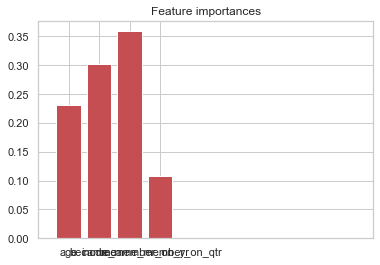

In [468]:
evaluate_results(parameters)

In [754]:


model = joblib.load("classifier.pkl")

    
df = prepare_data().drop(["gender","became_member_on"], axis=1)

#instantiate regressor
#rf = RandomForestClassifier(bootstrap=False, n_estimators=100)


#get x ans y
X = df.iloc[:,2:6]
y = df["valid"]

#train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
model.best_estimator_.feature_importances_

#model.best_estimator_.cv_results_

model.best_estimator_.score(X_test,Y_test)



0.6422888370971631

In [753]:


from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, model.predict(X_test))

conf_mat

array([[5458, 1554],
       [2893, 2538]])